### Popmodel - Artifical Neural Network Modelling
###### Imports

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import  KBinsDiscretizer
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
import gc
from livelossplot.inputs.tf_keras import PlotLossesCallback
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import time
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Dense
from sklearn.metrics import f1_score
import numpy as np

###### Notebook Settings

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)
sns.set_style("whitegrid")

###### Feature Engineering


In [3]:
#Read CSVs
data = pd.read_csv("SpotifyData.csv")
add_infos = pd.read_csv("additional_infos.csv")

In [4]:
#Adjust inconsistent genre naming
data.loc[data["genre"] == 'Children’s Music', "genre"] = "Children Music"
data.loc[data["genre"] == "Children's Music", "genre"] = "Children Music"

#Join duplicate tracks assigned to different genres together in one common row
genre_df = data.groupby(['track_id'])['genre'].apply(', '.join).reset_index()

#Drop duplicates by track ID and remove ID column
data.drop_duplicates("track_id", inplace=True)
data.sort_values("track_id", inplace=True)
data.reset_index(inplace=True, drop=True)

In [5]:
#Assign Features
X = data

In [6]:
#Replace genre column in original dataset
X["genre"] = genre_df["genre"]

#Genre encoding seperate since there can be multiple values in one row
X = pd.concat([X, X['genre'].str.get_dummies(sep=', ')], axis=1)
X = pd.concat([X, pd.get_dummies(X[["key","mode","time_signature"]])], axis=1)
X.drop(["key","mode","time_signature","genre"], axis=1, inplace=True)

#Add explicit feature from external dataset
add_infos.sort_values("id", inplace=True)
assert pd.Series(add_infos["id"].values == X["track_id"].values).value_counts().values[0] == len(add_infos)
X["explicit"] = add_infos["explicit"]
X["track_number"] = add_infos["track_number"]

#Get release Date from String and create new feature
temp = []
for i in range(len(add_infos)):
    temp += [int(add_infos["album"][i][add_infos["album"][i].find("release_date") + 16: add_infos["album"][i].find("release_date") + 20])]
X["release_date"] = temp
X.loc[X["release_date"] == 0000, "release_date"] = X["release_date"].values.mean().round()

#Get total track number from String and create new feature
temp = []
for i in range(len(add_infos)):
    if add_infos["album"][i][add_infos["album"][i].find("total_tracks") + 16] == ",":
        temp += [int(add_infos["album"][i][add_infos["album"][i].find("total_tracks") + 15: add_infos["album"][i].find("total_tracks") + 16])]
    elif add_infos["album"][i][add_infos["album"][i].find("total_tracks") + 17] == ",":
        temp += [int(add_infos["album"][i][add_infos["album"][i].find("total_tracks") + 15: add_infos["album"][i].find("total_tracks") + 17])]
    else:
        temp += [int(add_infos["album"][i][add_infos["album"][i].find("total_tracks") + 15: add_infos["album"][i].find("total_tracks") + 18])]
X["total_tracks"] = temp

#Get artist id from String and create new feature
temp = []
for i in range(len(add_infos)):
    temp += [add_infos["album"][i][add_infos["album"][i].find("id") + 6: add_infos["album"][i].find("id") + 28]]
X["artist_id"] = temp

#encoding track id and artist
lenc = OrdinalEncoder()
X["track_id"] = lenc.fit_transform(X["track_id"].values.reshape(-1,1))
X["artist_id"] = lenc.fit_transform(X["artist_id"].values.reshape(-1,1))
X["track_name"] = lenc.fit_transform(X["track_name"].values.reshape(-1,1))
X["artist_name"] = lenc.fit_transform(X["artist_name"].values.reshape(-1,1))

In [7]:
#Drop Songs with zero popularity
X.drop(X[X["popularity"] == 0].index, inplace=True)

In [8]:
#Drop voice only audio tracks
X.drop(X[X["speechiness"] > 0.70].index, inplace=True)

In [9]:
#Assign Prediction Target
y = X["popularity"]
X.drop(["popularity"], axis=1, inplace=True)

In [10]:
#Class binning of y
est = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
y = pd.DataFrame(est.fit_transform(y.values.reshape(-1, 1)))
y= to_categorical(y)

In [11]:
#Scaling all features
sc = StandardScaler()
X = sc.fit_transform(X)

###### Modeling

In [12]:
# split into 67% for train and 33% for test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


###### Classification Model

In [115]:
def build_class_model():
  model = Sequential([

    Dense(4000, activation='relu', input_shape=(63,),
    kernel_regularizer= keras.regularizers.l2(0.005),
    bias_regularizer=keras.regularizers.l2(0.005),
    activity_regularizer=keras.regularizers.l2(0.005)
    ),

    Dense(100, activation='relu',
    kernel_regularizer= keras.regularizers.l2(0.005),
    bias_regularizer=keras.regularizers.l2(0.005),
    activity_regularizer=keras.regularizers.l2(0.005)
    ),

    Dense(3, activation='softmax',
    kernel_regularizer= keras.regularizers.l2(0.005),
    bias_regularizer=keras.regularizers.l2(0.005),
    activity_regularizer=keras.regularizers.l2(0.005)
    ),
  ])

  model.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])
  return model

class_model = build_class_model()

5673

In [116]:
#Clear memory for a restart of the training process
del class_model
clear_session()
gc.collect()
gc.collect()

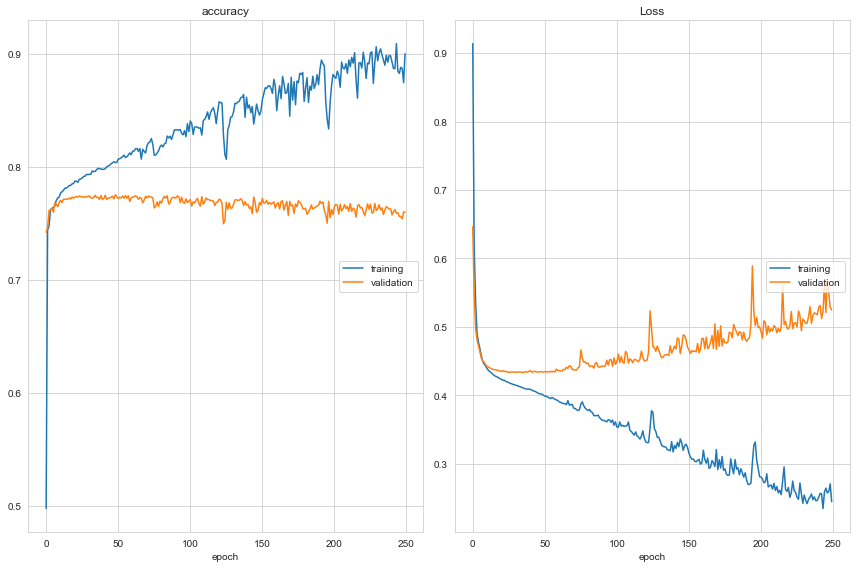

accuracy
	training         	 (min:    0.498, max:    0.909, cur:    0.900)
	validation       	 (min:    0.742, max:    0.775, cur:    0.760)
Loss
	training         	 (min:    0.235, max:    0.914, cur:    0.245)
	validation       	 (min:    0.433, max:    0.646, cur:    0.525)
3/3 [==============================] - 1s 181ms/step - loss: 0.2447 - accuracy: 0.9000 - val_loss: 0.5246 - val_accuracy: 0.7598


In [117]:
# train the model
class_model  = class_model.fit(X_train, y_train, epochs=250, batch_size=50000,
                   validation_data=(X_test, y_test),
                   callbacks=[PlotLossesCallback()],
                   verbose=1
                   )

In [80]:
f1_score(np.argmax(y_test, axis=1), np.argmax(class_model.predict(X_test), axis=1), average='weighted')

0.7516596990347801

In [ ]:
start = time.time()
estimator = KerasClassifier(build_fn=build_class_model, epochs=250, batch_size=50000, verbose=0)
kfold = KFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, X, y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
print(time.time() - start)


##### Regression Model

In [141]:
def build_reg_model():
    model = keras.Sequential([
    Dense(8000, activation='relu', input_shape=(63,)),
    Dense(200, activation="relu"),
    Dense(20, activation="relu"),
    Dense(1, activation="linear")
    ])

    model.compile(loss="mse",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.006, beta_1=0.8, amsgrad=True),
                metrics=["RootMeanSquaredError", "mae"]
                )
    return model

reg_model = build_reg_model()

In [ ]:
#Clear memory for a restart of the training process
del reg_model
clear_session()
gc.collect()
gc.collect()

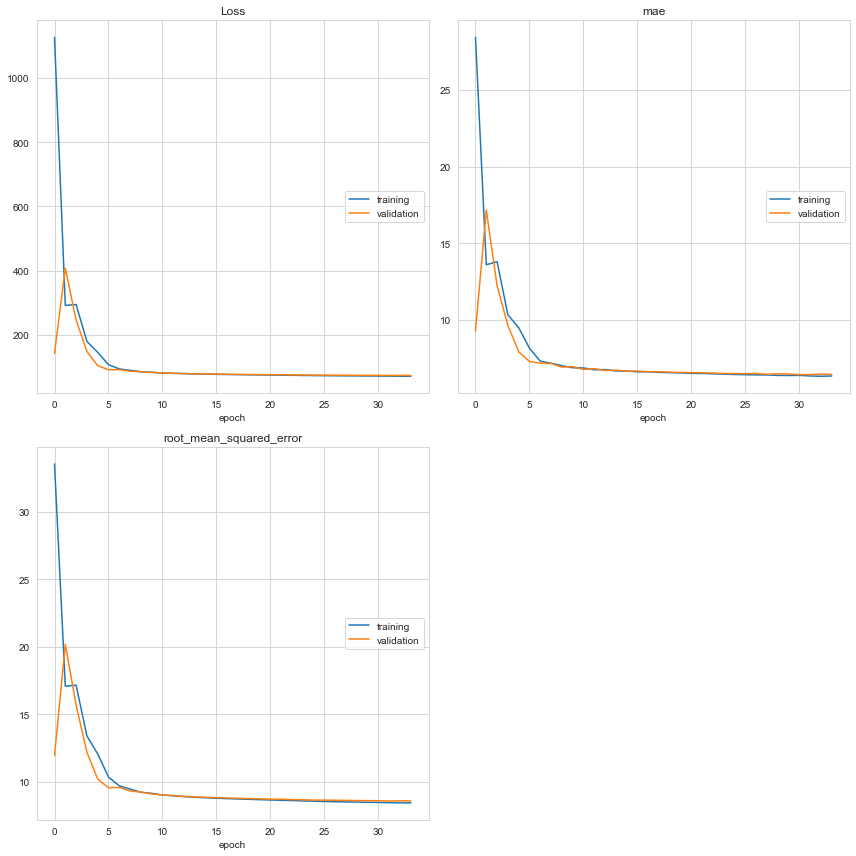

Loss
	training         	 (min:   71.077, max: 1126.921, cur:   71.077)
	validation       	 (min:   73.420, max:  407.526, cur:   73.423)
mae
	training         	 (min:    6.338, max:   28.434, cur:    6.354)
	validation       	 (min:    6.438, max:   17.182, cur:    6.455)
root_mean_squared_error
	training         	 (min:    8.431, max:   33.570, cur:    8.431)
	validation       	 (min:    8.569, max:   20.187, cur:    8.569)


KeyboardInterrupt: 

In [142]:
n_idle_epochs = 100
#earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=n_idle_epochs, min_delta=0.01)

# train the model
reg_model  = reg_model.fit(X_train, y_train, epochs=250, batch_size=50000,
               validation_data=(X_test, y_test),
               callbacks=[PlotLossesCallback()],
               verbose=0
               )